# Multimodal Embeddings With Langchain

- Author: [Gwangwon Jung](https://github.com/pupba)
- Design: []()
- Peer Review: [krkrong](https://github.com/krkrong), [teddylee777](https://github.com/teddylee777)
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/08-Embeeding/08-MultiModalEmbeddings.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/08-Embeeding/08-MultiModalEmbeddings.ipynb)

## Overview

This tutorial covers how to perform `Text Embedding` or `Image Embedding` using `Multimodal Embedding Model` and `Langchain`.

The `Multimodal Embedding Model` is a model that can vectorize `Text` as well as `Image`.

In this tutorial, we will create a simple **Image Similarity Searching** example using `Multimodal Embedding Model` and `Langchain`.

![example](./assets/example-flow-image-search-with-mm-embedding.png)

### Table of Contents

- [Overview](#overview)
- [Environement Setup](#environment-setup)
- [Multimodal Embedding](#multimodal-embedding)
- [What is Image Similarity Search?](#what-is-image-similarity-search?)
- [Setting Image Data](#setting-image-data)
- [Model Load and Embedding Images](#model-load-and-embedding-images)
- [Image Similarity Search with Text](#image-similarity-search-with-text)
- [Image Similarity Search with Image](#image-similarity-search-with-image)

### References

- [Multimodal Embedding](https://learn.microsoft.com/en-us/azure/ai-services/computer-vision/concept-image-retrieval)
- [Similarity Search](https://en.wikipedia.org/wiki/Similarity_search)
- [OpenCLIP](https://github.com/mlfoundations/open_clip)
----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [15]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langchain-experimental",
        "pillow",
        "open_clip_torch",
        "scikit-learn",
        "numpy",
        "requests",
    ],
    verbose=False,
    upgrade=False,
)

## Multimodal Embedding

Multimodal embedding is the process of creating a vector that represents an image’s features and context, making it compatible with text search in the same vector space.

![Concept of Mutlimodal Embedding](./assets/multimodal-embedding-concept.png)

## What is Image Similarity Search?

**Image Similarity Search** is a technique that allows you to find images in a database that are similar to a given query (either an image or text describing the image) using vector-based representations. 

The process involves converting images or text into embedding vectors that capture their visual or semantic features.

These vectors are then compared using similarity metrics, such as `Cosine Similarity` or `Euclidean Distance`, to find the most similar images in the database based on their vector representations.

## Setting Image Data

In this tutorial, example images are provided. These images are copyright-free and cover a variety of topics (e.g., dog, cat, female, male,...) created using `SDXL`.

The images are located at `./data/for_embed_images.zip`.

Create a list containing the image path.

In [108]:
# Unzip to image dataset
import zipfile
import tempfile
import os


def extract_zip_to_tempdir(zip_file_path: str) -> str:
    """
    Extract a ZIP file containing .png images to a temporary directory.

    Args:
        zip_file_path (str): Path to the ZIP file.

    Returns:
        str: Path to the temporary directory containing the extracted files.
    """
    # Create a temporary directory
    temp_dir = tempfile.mkdtemp()

    # Extract ZIP file contents to the temporary directory
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(temp_dir)

    return temp_dir

In [ ]:
from PIL import Image

# in colab : "os.getcwd()" replace to "<your-drive-path>"

DATA_ROOT_DIR = os.path.join(
    os.getcwd(), "08-EMBEDDING", "data", "for_embed_images.zip"
)

image_temp_dir = extract_zip_to_tempdir(DATA_ROOT_DIR)

image_path_db = [
    os.path.join(image_temp_dir, img_n)
    for img_n in os.listdir(image_temp_dir)
    if img_n.endswith(".png")
]

## Model Load and Embedding Images

In this tutorial, we use `OpenCLIP`, which implements OpenAI's `CLIP` as an open source.

- [OpenCLIP Github](https://github.com/mlfoundations/open_clip)

`OpenCLIP` can be used with `Langchain` to easily embed **Text** and **Image** .

You can load `OpenCLIP Embedding` model using the `Python` libraries `open_clip_torch` and `langchain-experimental`.

In [7]:
# List of (Model,Checkpoint)
import open_clip

open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_image_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_text_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_basic_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_s13m_b4k'),
 ('ViT-

In [8]:
# model and checkpoint setting

MODEL = "ViT-g-14"
CHECKPOINT = "laion2b_s34b_b88k"

In [9]:
# model load
from langchain_experimental.open_clip import OpenCLIPEmbeddings

clip_embedding = OpenCLIPEmbeddings(
    model_name=MODEL,
    checkpoint=CHECKPOINT,
)

# Show Model Architecture
clip_embedding

OpenCLIPEmbeddings(model=CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((1408,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-39): 40 x ResidualAttentionBlock(
          (ln_1): LayerNorm((1408,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1408, out_features=1408, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((1408,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1408, out_features=6144, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((140

In [111]:
# Embedding Images
# It takes a very long time at Colab. I recommend replacing it with a small model.
image_vector_db = clip_embedding.embed_image(image_path_db)

In [19]:
# Preprocessing for Image Similarity Search
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import numpy as np


def combine_images_vertically(images: list) -> Image.Image:
    """
    Combine the given image path list vertically and save it as a single image.

    Args:
        images (list): PIL Image List to combine.

    Returns:
        combined_image (Image.Image): A single image with all input images combined vertically.
    """

    # Extract dimensions of each image
    widths, heights = zip(*(img.size for img in images))

    # Calculate the dimensions of the combined image
    max_width = max(widths)
    total_height = sum(heights)

    # Create a blank canvas with the calculated dimensions
    combined_image = Image.new("RGB", (max_width, total_height))

    # Paste each image onto the canvas one below the other
    y_offset = 0
    for img in images:
        combined_image.paste(img, (0, y_offset))
        y_offset += img.height

    return combined_image

## Image Similarity Search with Text

`Image Similarity Search with Text` finds the image in the image dataset that most relates to a given `text query`.

We will use `Cosine Similarity` for calculation of similarity.

Because `Cosine Similarity` is commonly used in image similarity search.

### Steps

1. Text Query Embedding

2. Calculate the similarity between the `Text Query Embedding Vector` and the `Image Embedding Vector`

3. Get similar images

In [71]:
"""
OpenCLIP Embedding must explain the image in detail 
to produce meaningful results of similarity in the future.
"""

text_query = "a cat with green eyes,pink flowers,tree"

In [72]:
# Text Query Embedding
text_query_embedding_vector = clip_embedding.embed_query(text_query)

In [112]:
# Get Similarity
similarity = cosine_similarity(
    normalize(np.array(text_query_embedding_vector).reshape(1, -1)),
    normalize(np.array(image_vector_db)),
)

sorted_idx = similarity.argsort()[0][::-1]

In [113]:
for i, idx in enumerate(sorted_idx):
    # window : \\
    # mac, linux : /
    file_name = image_path_db[idx].split("\\")[-1]  # default window
    print(f"Similarity Rank{i+1} : {similarity[0][idx]:.3f} | {file_name}")

Similarity Rank1 : 0.297 | cat_00005_.png
Similarity Rank2 : 0.287 | cat_00007_.png
Similarity Rank3 : 0.283 | cat_00014_.png
Similarity Rank4 : 0.279 | cat_00006_.png
Similarity Rank5 : 0.272 | cat_00016_.png
Similarity Rank6 : 0.265 | cat_00008_.png
Similarity Rank7 : 0.260 | cat_00015_.png
Similarity Rank8 : 0.255 | cat_00013_.png
Similarity Rank9 : 0.186 | dog_00006_.png
Similarity Rank10 : 0.167 | cat_00002_.png
Similarity Rank11 : 0.164 | dog_00008_.png
Similarity Rank12 : 0.152 | cat_00003_.png
Similarity Rank13 : 0.150 | tree_00002_.png
Similarity Rank14 : 0.149 | cat_00004_.png
Similarity Rank15 : 0.146 | cat_00001_.png
Similarity Rank16 : 0.145 | dog_00009_.png
Similarity Rank17 : 0.141 | cat_00010_.png
Similarity Rank18 : 0.140 | tree_00004_.png
Similarity Rank19 : 0.140 | tree_00003_.png
Similarity Rank20 : 0.136 | dog_00011_.png
Similarity Rank21 : 0.133 | dog_00010_.png
Similarity Rank22 : 0.127 | dog_00002_.png
Similarity Rank23 : 0.126 | dog_00007_.png
Similarity Rank24

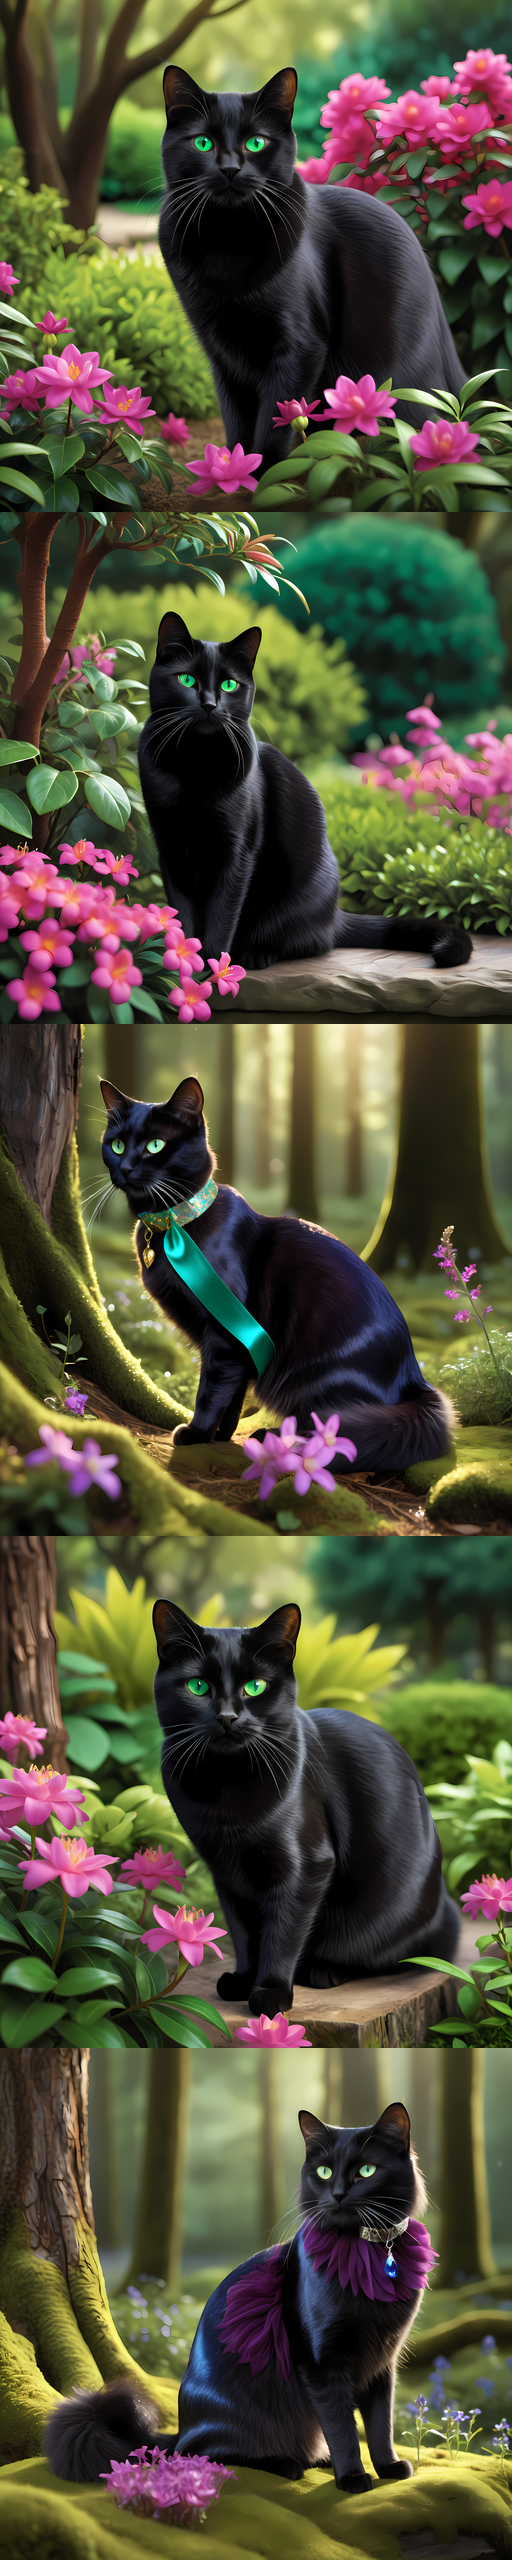

In [114]:
# Get similarity images Top5 Rank
top5 = sorted_idx[:5]

comb_imgs = combine_images_vertically([Image.open(image_path_db[idx]) for idx in top5])
comb_imgs

## Image Similarity Search with Image

`Image Similarity Search with Image` finds the image in the image dataset that most relates to a given `Image query`.

We will use `Cosine Similarity` for calculation of similarity.

Because `Cosine Similarity` is commonly used in image similarity search.

### Steps

1. Image Query Embedding

2. Calculate the similarity between the `Image Query Embedding Vector` and the `Image Embedding Vector`

3. Get similar images

In [89]:
# query image url
import requests
from io import BytesIO


def load_image_from_url(url: str, resolution: int = 512) -> Image.Image:
    """
    Load an image from a URL and return it as a PIL Image object.

    Args:
        url (str): The URL of the image.

    Returns:
        Image.Image: The loaded PIL Image object.
    """
    response = requests.get(url)
    response.raise_for_status()  # Raise an error for failed requests
    image = Image.open(BytesIO(response.content))
    image = image.resize((resolution, resolution), resample=Image.Resampling.LANCZOS)
    return image

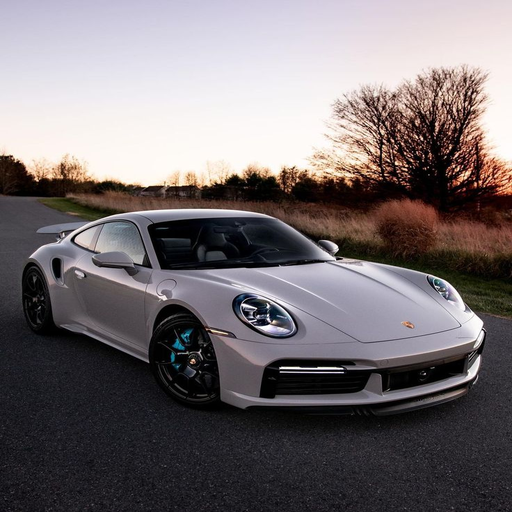

In [115]:
img_url = "https://i.pinimg.com/736x/85/0a/ca/850aca7cd77c110e99ab20862aef14cf.jpg"

image_query = load_image_from_url(img_url)
image_query

In [116]:
def save_image_to_tempfile(url: str) -> str:
    """
    Download an image from a URL and save it to a temporary file.

    Args:
        url (str): The URL of the image.

    Returns:
        str: The file path to the saved image.
    """
    response = requests.get(url)

    # Raise an error for failed requests
    response.raise_for_status()

    # Create a temporary file
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".jpg")
    temp_file.write(response.content)

    # Close the file to allow other processes to access it
    temp_file.close()
    return temp_file.name

In [117]:
# Image Embedding
# Save Temp file used image url
image_query_url = save_image_to_tempfile(img_url)

# Image Embedding
image_query_vector = clip_embedding.embed_image([image_query_url])

# Remove Temp file
os.remove(image_query_url)

In [118]:
similarity = cosine_similarity(
    normalize(np.array(image_query_vector)),
    normalize(np.array(image_vector_db)),
)

sorted_idx = similarity.argsort()[0][::-1]

In [119]:
for i, idx in enumerate(sorted_idx):
    # window : \\
    # mac, linux : /
    file_name = image_path_db[idx].split("\\")[-1]  # default window
    print(f"Similarity Rank{i+1} : {similarity[0][idx]:.3f} | {file_name}")

Similarity Rank1 : 0.442 | car_00009_.png
Similarity Rank2 : 0.434 | car_00010_.png
Similarity Rank3 : 0.428 | car_00011_.png
Similarity Rank4 : 0.414 | car_00012_.png
Similarity Rank5 : 0.401 | car_00013_.png
Similarity Rank6 : 0.394 | car_00001_.png
Similarity Rank7 : 0.385 | car_00015_.png
Similarity Rank8 : 0.380 | car_00002_.png
Similarity Rank9 : 0.371 | car_00016_.png
Similarity Rank10 : 0.370 | car_00006_.png
Similarity Rank11 : 0.365 | car_00014_.png
Similarity Rank12 : 0.357 | car_00003_.png
Similarity Rank13 : 0.353 | car_00005_.png
Similarity Rank14 : 0.337 | car_00004_.png
Similarity Rank15 : 0.335 | car_00008_.png
Similarity Rank16 : 0.326 | car_00007_.png
Similarity Rank17 : 0.318 | male_00004_.png
Similarity Rank18 : 0.305 | male_00003_.png
Similarity Rank19 : 0.289 | male_00001_.png
Similarity Rank20 : 0.288 | male_00013_.png
Similarity Rank21 : 0.284 | male_00012_.png
Similarity Rank22 : 0.278 | male_00007_.png
Similarity Rank23 : 0.277 | male_00006_.png
Similarity Ra

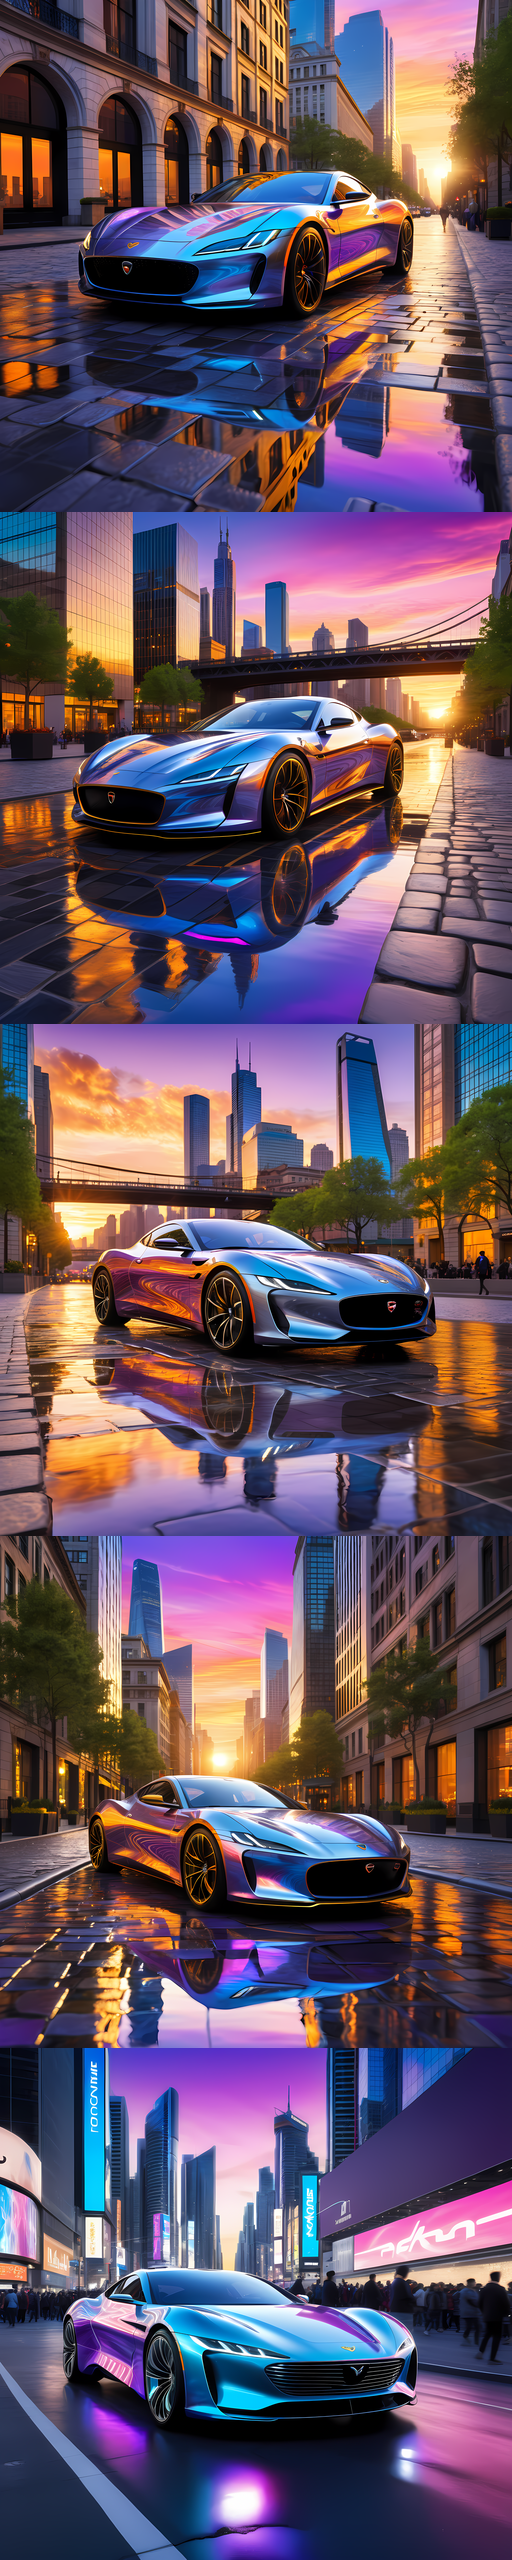

In [120]:
# Get similarity images Top5 Rank
top5 = sorted_idx[:5]

comb_imgs = combine_images_vertically([Image.open(image_path_db[idx]) for idx in top5])
comb_imgs

In [121]:
# Clean up temporary directory manually if needed
import shutil

shutil.rmtree(image_temp_dir)